## import libraries

In [90]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator #to increase dataset
from tensorflow.keras.applications import MobileNetV2 #pre trained model on many type of image 
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout #to decrease overfitting
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense #create hidden layer
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input #preparing format of image to -1 to +1 px 
from tensorflow.keras.preprocessing.image import img_to_array #convert from img to array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical #from vector to matrix
from sklearn.preprocessing import LabelBinarizer #to encode dataset -- with mask = 1 , without mask == 0
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd




# Data load and processing

### Initialize the initial Learning rate, number of epochs to train for,and batch size

In [58]:
INIT_LR = 1e-4 #0.0001
EPOCHS = 20
BS = 32

### grab the List of images in our dataset directory, then initialize the List of data (i.e., images) and class images

In [41]:
#Dataset source =https://github.com/balajisrinivas/Face-Mask-Detection/tree/master/dataset
DIRECTORY = r'./dataset'
CATEGORIES = ["with_mask",'without_mask']

print('[INFO] loading images....')

data = [] #for img
labels = [] #"with_mask",'without_mask'

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224,224) )
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append( image)
        labels.append(category)

[INFO] loading images....


d:\miniconda3\envs\mack_Det\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
#data

In [43]:
pd.DataFrame(labels).value_counts()

without_mask    1918
with_mask       1915
dtype: int64

### perform one-hot encoding on the Labels and train test split

In [44]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels) #converted from vector to  matrix

data = np.array(data, dtype="float32")
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(data,labels, test_size=0.20,stratify=labels ,random_state=42)


In [47]:
X_train.shape

(3066, 224, 224, 3)

In [48]:
y_train.shape

(3066, 2)

### construct the training image generator for data augmentation

In [50]:
aug = ImageDataGenerator(
    rotation_range=20 ,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip =True,
    fill_mode = 'nearest')

### load the MobiLeNetV2 network, ensuring the head FC Layer sets are Left off

In [51]:
baseMode1 = MobileNetV2( weights='imagenet' ,include_top=False, input_tensor=Input(shape=(224, 224, 3)) )

9406464/9406464 [==============================] - 2s 0us/step


### construct the head of the model that wiLL be placed on top of the the base model

In [52]:
headMode1= baseMode1. output
headMode1 = AveragePooling2D(pool_size=(7, 7))(headMode1)
headMode1 = Flatten( name= "flatten" )(headMode1)
headMode1 = Dense(128, activation ='relu')(headMode1)
headMode1 = Dropout(0.5)(headMode1)
headMode1 = Dense(2, activation="softmax")(headMode1)

### place the head FC model on top of the base model (this wit L become the actual model we will train)

In [53]:
model =Model(inputs = baseMode1.input, outputs=headMode1)

### Loop over all Layers in the base model and freeze them so they will *not* be updated during the first training process

In [54]:
for layer in baseMode1.layers:
    layer.trainable = False

# Compile our model

In [60]:
import tensorflow as tf
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=10000,
    decay_rate=INIT_LR / EPOCHS)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [61]:
model.compile(loss= 'binary_crossentropy', optimizer=opt, metrics = ["accuracy" ] )

# train the head of the network

In [63]:
print('[INFO] training head....')
H = model.fit(
    aug.flow(X_train, y_train, batch_size = BS), # BS = 32
    steps_per_epoch=len(X_train) // BS , 
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // BS,
    epochs = EPOCHS)
    

[INFO] training head....
Epoch 1/20
95/95 [==============================] - 186s 2s/step - loss: 0.4242 - accuracy: 0.8303 - val_loss: 0.1622 - val_accuracy: 0.9870
Epoch 2/20
95/95 [==============================] - 159s 2s/step - loss: 0.1622 - accuracy: 0.9618 - val_loss: 0.0847 - val_accuracy: 0.9922
Epoch 3/20
95/95 [==============================] - 159s 2s/step - loss: 0.1167 - accuracy: 0.9680 - val_loss: 0.0638 - val_accuracy: 0.9922
Epoch 4/20
95/95 [==============================] - 159s 2s/step - loss: 0.0826 - accuracy: 0.9782 - val_loss: 0.0546 - val_accuracy: 0.9922
Epoch 5/20
95/95 [==============================] - 140s 1s/step - loss: 0.0783 - accuracy: 0.9776 - val_loss: 0.0493 - val_accuracy: 0.9922
Epoch 6/20
95/95 [==============================] - 132s 1s/step - loss: 0.0662 - accuracy: 0.9812 - val_loss: 0.0436 - val_accuracy: 0.9922
Epoch 7/20
95/95 [==============================] - 143s 2s/step - loss: 0.0663 - accuracy: 0.9855 - val_loss: 0.0413 - val_accur

# make predictions on the testing set

In [81]:
print('[info] evaluating network... ')
predIdxs = model.predict(X_test, batch_size = BS)

[info] evaluating network... 
24/24 [==============================] - 17s 710ms/step


### for each image in the testing set we need to find the index of the Label with corresponding Largest predicted probability

In [82]:
predIdxs = np.argmax(predIdxs , axis = 1)

# classification report

In [83]:
print(classification_report(y_test.argmax(axis=1), predIdxs, target_names =  lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



# serialize the model to disk

In [85]:
print(" [INFO] saving mask detector model... ")
model.save( "mask_detector.model" , save_format = 'h5' )

 [INFO] saving mask detector model... 


# plot the training Loss and accuracy

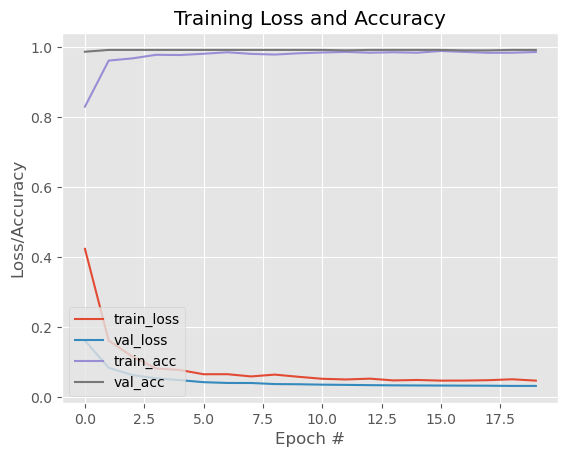

In [92]:
%matplotlib inline
N = EPOCHS
plt.style.use( "ggplot" )
plt.plot(np.arange(0,N),H.history["loss"] , label='train_loss')
plt.plot (np.arange(0,N), H.history["val_loss"] , label='val_loss')
plt.plot (np.arange(0,N), H.history["accuracy"] , label='train_acc')
plt.plot(np.arange(0,N), H.history["val_accuracy"] , label='val_acc')
plt.title('Training Loss and Accuracy')
plt.xlabel("Epoch #")
plt.ylabel( "Loss/Accuracy" )
plt.legend(loc= 'lower left')
plt.savefig( "plot.png" )